# <div style="text-align:center; color:rgba(37, 40, 80);">11753 Computational Intelligence</div>
# <div style="text-align:center; color:rgba(37, 40, 80);">Master in Intelligent Systems</div>
# <div style="text-align:center; color:rgba(37, 40, 80);">Universitat de les Illes Balears</div>

### <div style="text-align:center; color:white;"> Handout #2: **Feed-forward Neural Networks (FFNN)**</div>

#### **Integrants:** Jason Adel Noboa Rivera, Pedro Marti Pico
#### **Group:** 06


In [6]:
from pandas import read_csv
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.utils import to_categorical
import numpy as np
import tensorflow as tf
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping

In [7]:
def load_data(split):

    # Load train data
    data = read_csv('ds1-06-%d-nn-tr.csv' % split)
    X_train = data.iloc[:, :-1].to_numpy()
    y_train = data.iloc[:, -1].to_numpy()

    # Load test data
    data = read_csv('ds1-06-%d-nn-te.csv' % split)
    X_test = data.iloc[:, :-1].to_numpy()
    y_test = data.iloc[:, -1].to_numpy()
    
    # One-hot encoding
    y_train_OHE_OHE = to_categorical(y_train, num_classes=5)
    y_test_OHE_OHE = to_categorical(y_test, num_classes=5)

    return X_train, y_train, X_test, y_test, y_train_OHE_OHE, y_test_OHE_OHE

As many output neurons as categories --> use softmax and train with (pg44)

In [8]:
def create_model(layer_neurons, activation_function, learning_rate=0.1, metrics=['accuracy'], decay_steps=1000, decay_rate=0.96, loss_function='categorical_crossentropy', output_neurons=5, dynamic = False, optimizer = tf.keras.optimizers.SGD):
    model = tf.keras.models.Sequential()
    
    # Add hidden layers with specified number of neurons and activation function
    for neurons in layer_neurons:
        model.add(tf.keras.layers.Dense(neurons, activation=activation_function))
    
    if dynamic == True:
        lr = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=decay_steps,
            decay_rate=decay_rate)
    else: # Para primeras tareas
        lr = learning_rate

    # Output layer with softmax activation for multi-class classification
    model.add(tf.keras.layers.Dense(output_neurons, activation='softmax'))

    # Compile the model with the specified optimizer and loss function
    model.compile(optimizer =  optimizer(learning_rate=lr), 
                  loss = loss_function, 
                  metrics = metrics)

    return model

### T1. Start with a basic configuration: a single hidden layer network and the most basic activation function. Try with three different amounts of neurons, and keep the best configuration for the next task.
### For training, set a fixed learning rate, the most basic optimizer, a reasonable batch size, the most direct loss function and choose enough epochs to let the training converge. Tune the learning rate until you achieve convergence and a reasonable performance. To measure performance, use the accuracy for the test set.


Now we can proceed to create a a one-layer network and try it on a different amount of neurons.

In [39]:
# Load data
X_train, y_train, X_test, y_test, y_train_OHE, y_test_OHE = load_data(1)

neurons_amount = [10,50,100] # Different neuron counts to test

for neurons in neurons_amount:
    promed = [] # List to store performance metrics for averaging
    model = create_model([neurons],  activation_function='relu')
    for i in range(5): # Repeat training and evaluation 5 times for consistency
        model.fit(X_train, y_train_OHE, epochs = 50, batch_size = 32, verbose=0) # Training the model
        performance = model.evaluate(X_test, y_test_OHE, verbose=0) # Evaluating the model
        promed.append(performance[1])
    print(f"Neurons: {neurons}, Test Accuracy (median): {np.mean(promed)}") # Printing the average accuracy

Neurons: 10, Test Accuracy (median): 0.9185628652572632
Neurons: 50, Test Accuracy (median): 0.9245509028434753
Neurons: 100, Test Accuracy (median): 0.9269461154937744


In this task we used the `relu` activation function and the `categorical_crossentropy` with a OneHotEncoding as our lose function, We take these functions as the simplest and best known to start the training. As it can see, the best performance is in the biggest amount, having an accuracy of 92.69%, bigger than the other amounts of neurons. So, we consider to take that amount of `100` neurons as the best configuration and test it for the following task.

### T2. Next, check whether a change in the activation function of the hidden layer neurons improves the classification performance. If that is the case, continue with the alternative activation function.

In order to test if a change in the activation functions can work better then the previous one in T1, we are going to test it in a different amount of activation functions. With that, we will test the most used activation functions and we will be able to compare a reasonable amount of activation functions in order to choose the better one.

In [10]:
# Activation functions used for T2
activation_functions = ['relu','sigmoid', 'tanh', 'leaky_relu', 'elu', 'selu'] 

for activation in activation_functions:
    model = create_model([100], activation)
    model.fit(X_train, y_train_OHE, epochs=50, batch_size=32, verbose=0)
    performance = model.evaluate(X_test, y_test_OHE, verbose=0)
    print(f"Neurons: {neurons}, Activation: {activation}, Test Accuracy: {performance[1]}")

Neurons: 100, Activation: relu, Test Accuracy: 0.9221556782722473
Neurons: 100, Activation: sigmoid, Test Accuracy: 0.796407163143158
Neurons: 100, Activation: tanh, Test Accuracy: 0.9071856141090393
Neurons: 100, Activation: leaky_relu, Test Accuracy: 0.910179615020752
Neurons: 100, Activation: elu, Test Accuracy: 0.9131736755371094
Neurons: 100, Activation: selu, Test Accuracy: 0.8982036113739014


As it is shown, the best performance of the activations is the `relu` activation the initial one, reaching a 92.21% of accuracy. There are other functions such as `elu` or `leaky_realu` that achieve a similar percentage so they could be options, however for this occasion, we choose the initial function. 

#### T3. Try with a dynamic learning rate and use it from now on if the performance does not get worse.
To evaluate the performance of a dynamic learning rate we have chosen an exponential decay and to evaluate the best performance we have implemented several different parameter values for `decay_steps` and `decay_rate`.

In [27]:
# Different decay configurations
decays = [[10,0.5],[1000,0.3],[1000,0.5],[1000,0.96],[10000,0.9]]

for d_step, d_rate in decays: # Create model with dynamic LR
    model = create_model( 
        layer_neurons=[100],
        activation_function='relu', 
        decay_steps=d_step,
        decay_rate=d_rate,
        dynamic = True
    )

    model.fit(X_train, y_train_OHE, epochs=50, batch_size=32, verbose=0)
    performance = model.evaluate(X_test, y_test_OHE, verbose=0)

    # Printing accuracy for each learning rate decay configuration
    print(f"Accuracy using Dynamic Learning Rate with ({d_step}) and ({d_rate}): : {performance[1]}")

Accuracy using Dynamic Learning Rate with (10) and (0.5): : 0.6756756901741028
Accuracy using Dynamic Learning Rate with (1000) and (0.3): : 0.9009009003639221
Accuracy using Dynamic Learning Rate with (1000) and (0.5): : 0.9069069027900696
Accuracy using Dynamic Learning Rate with (1000) and (0.96): : 0.912912905216217
Accuracy using Dynamic Learning Rate with (10000) and (0.9): : 0.9009009003639221


The decision has been taken to choose a dynamic learning rate to guarantee the convergence of the model, and as a result of the previous evaluation, the values for `decay_steps` and `decay_rate` were chosen to be 1000 and 0.96 respectively. So we will keep a dynamic learning rate from here. 

### T4. Change to an alternative optimizer and keep it if the performance gets better.

In [12]:
# Optimizers used for T4
optimizers = [tf.keras.optimizers.SGD,
              tf.keras.optimizers.Adam, 
              tf.keras.optimizers.Adadelta, 
              tf.keras.optimizers.RMSprop]

for optimizer in optimizers: # Create model with each optimizer
    model = create_model(
        layer_neurons=[100],
        activation_function='relu',
        decay_steps=1000,
        decay_rate=0.96,
        dynamic = True,
        optimizer= optimizer
    )

    model.fit(X_train, y_train_OHE, epochs=50, batch_size=32, verbose=0)
    performance = model.evaluate(X_test, y_test_OHE, verbose=0)
    print(f"Accuracy using {optimizer}: {performance[1]}")

Accuracy using <class 'keras.src.optimizers.sgd.SGD'>: 0.92514967918396
Accuracy using <class 'keras.src.optimizers.adam.Adam'>: 0.886227548122406
Accuracy using <class 'keras.src.optimizers.adadelta.Adadelta'>: 0.8143712282180786
Accuracy using <class 'keras.src.optimizers.rmsprop.RMSprop'>: 0.8802395462989807


From the previous section it can be concluded that the optimiser we have chosen at the beginning is still the best option, as other optimisers only reduce the performance of the model, therefore we still keep `SGD` as our best option. 

#### T5. Switch to another loss function to check whether the performance level increases

In [29]:
# Different loss functions
loss_functions = ['categorical_crossentropy','sparse_categorical_crossentropy','Poisson', 'KLDivergence']
neurons = [100]

# Testing different loss functions
for loss_function in loss_functions:
    model = create_model(
        layer_neurons=neurons,
        activation_function='relu',
        decay_steps=1000,
        decay_rate=0.96,
        dynamic = True,
        optimizer=tf.keras.optimizers.SGD,
        loss_function=loss_function
    )
    
    # Conditional training based on loss function type (OHE or not)
    if('sparse_categorical_crossentropy' == loss_function): 
        model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)
        performance = model.evaluate(X_test, y_test, verbose=0)
    else:
        model.fit(X_train, y_train_OHE, epochs=50, batch_size=32, verbose=0)
        performance = model.evaluate(X_test, y_test_OHE, verbose=0)
    print(f"Accuracy using {loss_function}: {performance[1]}")

Accuracy using categorical_crossentropy: 0.9099099040031433
Accuracy using sparse_categorical_crossentropy: 0.9069069027900696
Accuracy using Poisson: 0.8558558821678162
Accuracy using KLDivergence: 0.9069069027900696


Similarly, different loss functions have now been evaluated, trying to ensure model consistency by choosing only loss functions from classification models. From this it can be obtained that the default loss function is the best option with 90.99%, however it is necessary to stress that the functions: `sparse_categorical_entropy` which is similar to only it does not need OneHotEncoding and `KLDivergence` have a good performance so they could be good options as well. 

#### T6. Add a second hidden layer with a reasonable number of neurons and check whether a performance gain is obtained. If that is the case, keep the second layer.

In [33]:
# Different configurations of neurons in layers
neurons = [[100],[100,50],[100,100], [100,150]] 

# Evaluating model performance with varying configurations of neurons in multiple layers
for neuron in neurons:
    model = create_model(
        layer_neurons=neuron,
        activation_function='relu',
        decay_steps=1000,
        decay_rate=0.96,
        dynamic = True,
        optimizer=tf.keras.optimizers.SGD,
        loss_function='categorical_crossentropy'
    )

    model.fit(X_train, y_train_OHE, epochs=50, batch_size=32, verbose=0)
    performance = model.evaluate(X_test, y_test_OHE, verbose=0)

    # Print accuracy based on layer configuration
    if len(neuron) == 1:
        print(f"Accuracy using one layer with {neuron[0]} neurons : {performance[1]}")
    else:
        print(f"Accuracy using {neuron[0]} neurons for first layer and {neuron[-1]} for second layer: {performance[1]}")

Accuracy using one layer with 100 neurons : 0.9009009003639221
Accuracy using 100 neurons for first layer and 50 for second layer: 0.9219219088554382
Accuracy using 100 neurons for first layer and 100 for second layer: 0.9309309124946594
Accuracy using 100 neurons for first layer and 150 for second layer: 0.9339339137077332


The results show a clear trend of incresing accuracy with adding more neurons to the second layer. The model withh a single 100 nueron layer had an accuracy of aproximatetly 90.09%. When a second layer is added of 50, 100 and 150 neurons, the accuracy has increased to about 92.19%, 93.09% and 93.38% respectively. This indicated that the additional complexity provided by the second layer is beneficial for this problem. Moreover, this suggest that our data and problem complexity can benefit from a deeper neural network, what means that the data patterns are complex and as more neurons and layers, better captured the data patterns.

So, based on the results, in order to choose the best model, the configuration with 100 neurons in the first layer and 150 in the second layer seems to be the most effective, achieving the highest accuracy among the others configrations.

#### T7. Try with larger and smaller batch sizes (one of each). You should observe that the training time also changes. Adopt the size leading to highest performance

In [15]:
batchs = [2,8,16,32,64,128]

# Testing model performance with different batch sizes
for batch in batchs:
    model = create_model(
        layer_neurons=[100,150],
        activation_function='relu',
        decay_steps=1000,
        decay_rate=0.96,
        dynamic = True,
        optimizer=tf.keras.optimizers.SGD,
        loss_function='categorical_crossentropy'
    )
    start_time = time.time() # Start timing
    model.fit(X_train, y_train_OHE, epochs=50, batch_size=batch, verbose=0)
    performance = model.evaluate(X_test, y_test_OHE, verbose=0)

    # Printing accuracy and execution time for each batch size
    print(f"Accuracy using batch of {batch}: {performance[1]}. Execution time = {time.time() - start_time}")

Accuracy using batch of 2: 0.946107804775238. Execution time = 18.778127908706665
Accuracy using batch of 8: 0.9491018056869507. Execution time = 5.681823492050171
Accuracy using batch of 16: 0.9341317415237427. Execution time = 3.51288104057312
Accuracy using batch of 32: 0.93113774061203. Execution time = 2.450622320175171
Accuracy using batch of 64: 0.8772454857826233. Execution time = 1.5919861793518066
Accuracy using batch of 128: 0.8832335472106934. Execution time = 1.2583990097045898


The highest accuracy is achieved with a batch size of 8, closely followed by a batch size of 2. As the batch size increases beyond 8, there's a noticeable drop in accuracy, where the smaller batch sizes (2 and 8) lead to better performance compared to larger ones (64 and 128).

The training time decreases as the batch size increases, which is expected. Larger batch sizes allow for more efficient computation by leveraging parallel processing capabilities of the hardware. The fastest training times are observed with larger batch sizes (64 and 128), but this comes at the cost of reduced accuracy.

So, in one hand the higher accuracy with these batch sizes suggests that the model benefits from more frequent updates of the weights. It could be that the model is better able to navigate the loss landscape and find a more optimal minimum. In the other hand, the decline in accuracy with larger batch sizes might be due to the model not being able to generalize as effectively. Larger batches provide a more approximate gradient, which could lead to convergence to less optimal points in the loss landscape.

So, we decided to choose the configuration of batch size 16 because it strikes an efficient balance between training speed and model accuracy, offering a good trade-off. This batch size provides high accuracy while keeping training times reasonably short, making it a practical choice for our application.

#### T8. For the best configuration found, determine the performance of the network using the accuracy, precision, recall and f1 metrics[2]. To this purpose, you have to:

#### a) Train the network for every one of the splits (using the corresponding training set). Show that the training has achieved convergence in each case by means of an appropriate plot.

#### b) Evaluate the network for every split (using the corresponding test set), reporting the confusion matrix and the aforementioned metrics.


====================================== EVALUATION WITH SPLIT 1 =======================================
Restoring model weights from the end of the best epoch: 51.
Epoch 66: early stopping


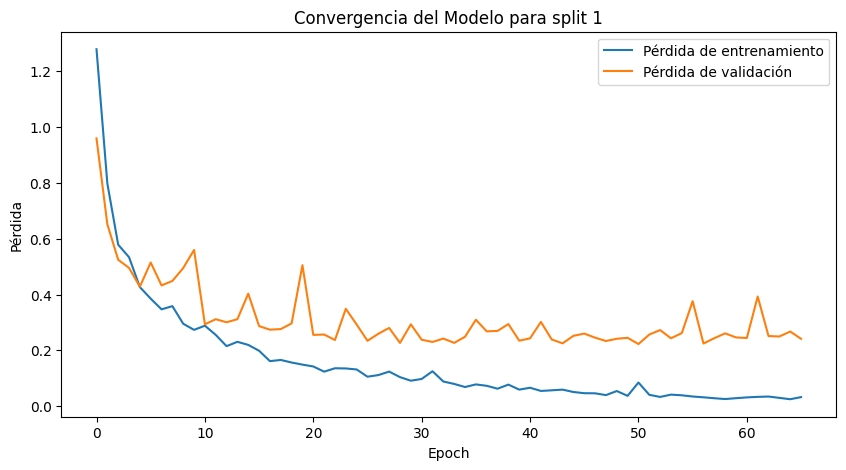

- CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.94      0.93      0.93        67
           1       0.89      0.88      0.89        67
           2       0.97      0.92      0.95        66
           3       0.94      0.97      0.96        67
           4       0.96      1.00      0.98        67

    accuracy                           0.94       334
   macro avg       0.94      0.94      0.94       334
weighted avg       0.94      0.94      0.94       334

- CONFUSION MATRIX



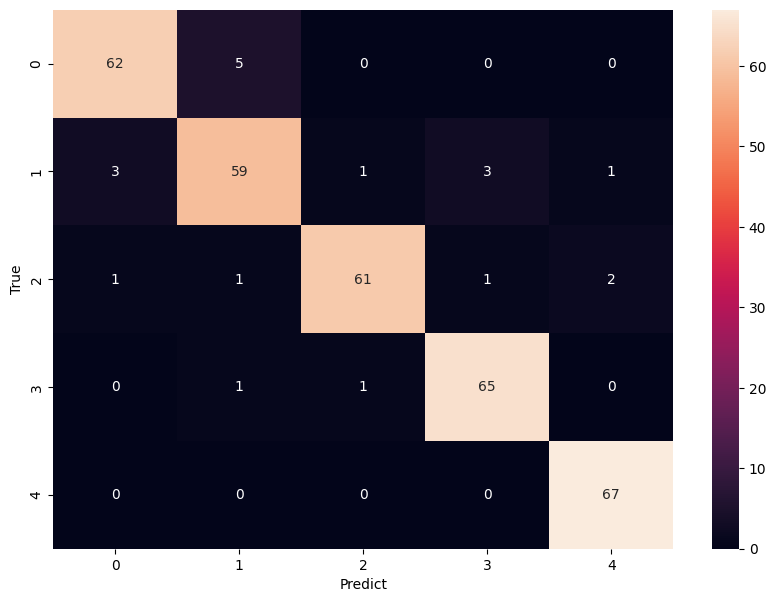


====================================== EVALUATION WITH SPLIT 2 =======================================
Restoring model weights from the end of the best epoch: 33.
Epoch 48: early stopping


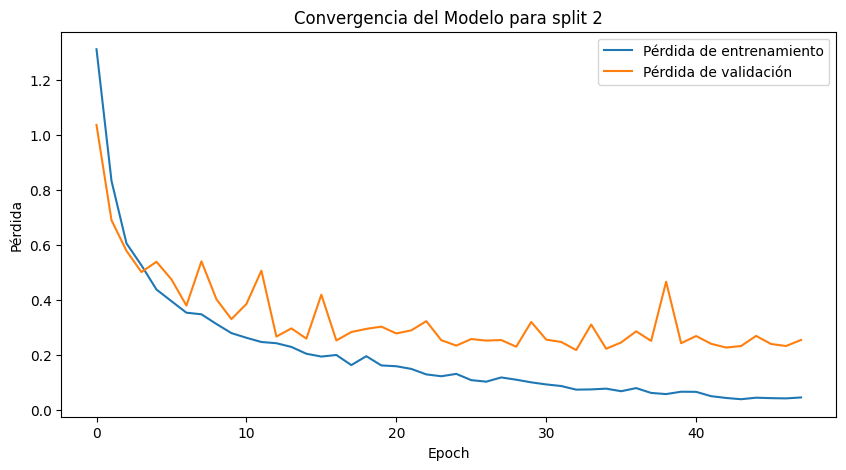

- CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.91      0.87      0.89        67
           1       0.89      0.94      0.91        66
           2       0.94      0.93      0.93        67
           3       0.94      0.93      0.93        67
           4       0.96      0.97      0.96        66

    accuracy                           0.92       333
   macro avg       0.93      0.93      0.92       333
weighted avg       0.93      0.92      0.92       333

- CONFUSION MATRIX



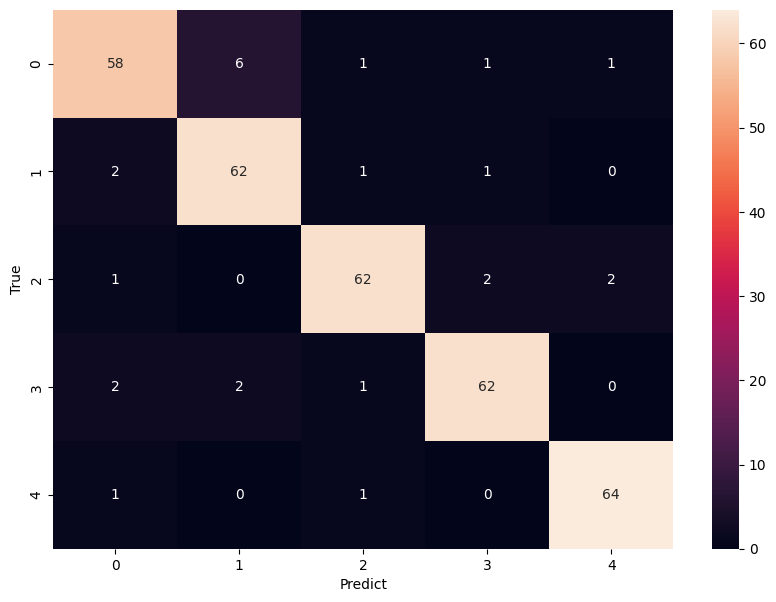


====================================== EVALUATION WITH SPLIT 3 =======================================
Restoring model weights from the end of the best epoch: 33.
Epoch 48: early stopping


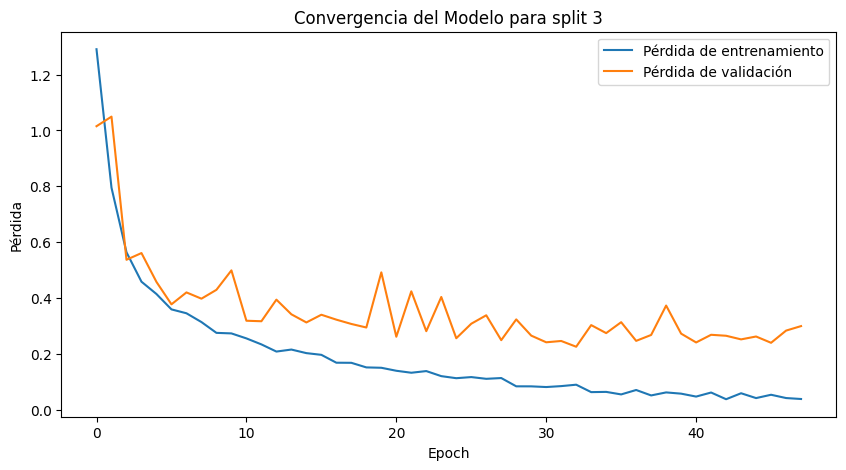

- CLASSIFICATION REPORT

              precision    recall  f1-score   support

           0       0.97      0.94      0.95        66
           1       0.94      0.93      0.93        67
           2       0.93      0.96      0.94        67
           3       0.94      0.97      0.96        66
           4       1.00      0.99      0.99        67

    accuracy                           0.95       333
   macro avg       0.96      0.95      0.96       333
weighted avg       0.96      0.95      0.96       333

- CONFUSION MATRIX



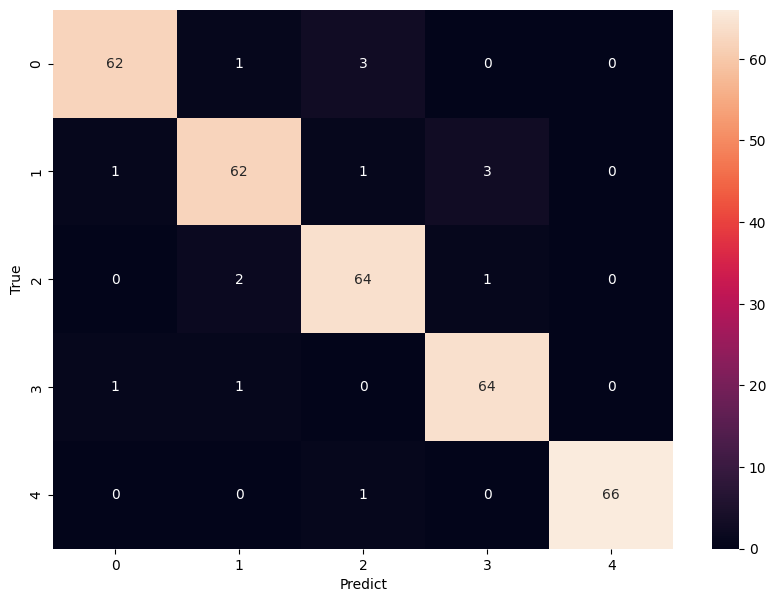

In [35]:
num_splits = 3
accuracies, precisions, recalls, f1s = [],[],[],[]

for split in range(1, num_splits + 1):
    print("\n======================================================================================================")
    print(f"====================================== EVALUATION WITH SPLIT {split} =======================================")
    
    X_train, y_train, X_test, y_test, y_train_OHE, y_test_OHE = load_data(split)
    
    # Using the best model configuration from previous tasks
    model = create_model(
        layer_neurons=[100,150],
        activation_function='relu',
        decay_steps=1000,
        decay_rate=0.96,
        dynamic = True,
        optimizer=tf.keras.optimizers.SGD,
        loss_function='categorical_crossentropy'
    )

    # Configuration of early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        verbose=1,
        restore_best_weights=True
    )

    historia = model.fit(X_train, y_train_OHE, validation_data=(X_test, y_test_OHE), epochs=200, batch_size=16, callbacks=[early_stopping], verbose=0)

    # Plot training and validation loss
    plt.figure(figsize=(10,5))
    plt.plot(historia.history['loss'], label='Pérdida de entrenamiento')
    plt.plot(historia.history['val_loss'], label='Pérdida de validación')
    plt.title(f'Convergencia del Modelo para split {split}')
    plt.xlabel('Epoch')
    plt.ylabel('Pérdida')
    plt.legend()
    plt.show()

    # HERE STARTS THE B)

    # Predict on test set
    y_pred = model.predict(X_test, verbose=0)

    # Generate and print classification report and confusion matrix
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test_OHE, axis=1)
    print("- CLASSIFICATION REPORT\n")
    print(classification_report(y_test_classes, y_pred_classes))
    print("- CONFUSION MATRIX\n")
    cm = confusion_matrix(y_test_classes, y_pred_classes)

    plt.figure(figsize=(10,7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predict')
    plt.ylabel('True')

    plt.show()

    # Calculate and append accuracy, precision, recall, and F1 score for the split
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)



**8a)** 

The training and validation loss curves from **Split 1** shows a strong start in learning, with rapid decrease in loss initially and a steady state reached quickly. The early stopping at epoch 70 indicates that the model's performance on the validation set ceased to improve, suggesting good convergence without overfitting. The occasional spikes in validation loss hint at the model's sensitivity to the nuances of the validation set but don't indicate a loss of generalization.

For **Split 2**, the model reached its optimal point more quickly, as indicated by the early stopping at epoch 50. The overall smoother descent of the validation loss, compared to Split 1, suggests that the model might have encountered a more straightforward optimization landscape. The lower epoch count at stopping could also point to a validation set that was less challenging for the model to generalize

The convergence pattern in **Split 3** is quite similar to Split 2, with early stopping again at epoch 50, implying consistency in the model's ability to learn and generalize across different data subsets. The validation loss remained low and stable post-convergence, which is indicative of a well-tuned model that generalizes well to unseen data.

Across all splits, the model demonstrates good convergence behavior with no signs of overfitting. The use of early stopping ensures that the model doesn't train beyond the point of optimal generalization, which is corroborated by the close tracking of training and validation loss curves. The consistent performance across splits in terms of convergence behavior indicates that the model's architecture and hyperparameters are well-suited to the dataset, capable of the adaptation to different data distributions in an efficient way.

**8b)** The classification reports indicate strong precision, recall, and F1 scores across all classes for each split. The consistently high values across these metrics suggest that the model is robust and generalizes well to unseen data.

- Split 1: The classification report and confusion matrix for Split 1 show excellent classification performance across all classes. With precision, recall, and F1 scores predominantly above 0.90, the model demonstrates a strong capacity to distinguish between the different classes accurately. The highest scores are seen in classes 2, 3, and 4, which might suggest these classes have more distinctive features or less overlap with other classes.

- Split 2: The model maintains high performance with all metrics comfortably above 0.87, reflecting its robustness. The slight increase in precision for classes 1 and 4 may point towards the model becoming more selective and confident in its predictions for these classes. However, a small decrease in accuracy compared to Split 1 could be indicative of subtle variations in the data distribution that present a slightly more challenging classification task for the model.

- Split 3: In this split the model achieves its best performance, with high precision and recall across all classes. This is evidenced by scores that are nearly perfect, notably a precision of 1.00 in class 4. Such high performance across all metrics suggests that the features in this split are exceptionally well captured by the model, leading to confident and accurate class predictions.

When comparing across the splits, the model shows a high level of consistency in its performance, with Split 3 being the best one in terms of metric scores. The consistent high precision and recall imply that the model is equally good at recognizing each class and avoiding false identifications. The slight variations in performance across splits are normal and reflect the differences in the data distribution of each split.

The results underscore the model's ability to generalize from the training data to unseen data effectively. Given these results, the model's architecture and the chosen hyperparameters seem to be well-optimized for the data currently used.

As an additional point, it can be said that by decreasing the value of the decay_rate of the dynamic learning rate to values like 0.5 a better convergence can be observed, i.e. a less noisy, smoother or "much straighter" validation loss, but reducing the overall model performance a bit, so it has been decided to use the value of 0.96 to obtain the best possible performance. 


#### c) Calculate and provide the average value for each metric.

In [36]:
avg_accuracy = np.mean(accuracies) 
avp_precision = np.mean(precisions)
avg_recall = np.mean(recalls)
avg_f1s = np.mean(f1s)

# Printing the average values of the metrics
print(f'Average accuracy: {avg_accuracy}')
print(f'Average precision: {avp_precision}')
print(f'Average recall: {avg_recall}')
print(f'Average f1-score: {avg_f1s}')


Average accuracy: 0.9399998801196405
Average precision: 0.9402216880828126
Average recall: 0.9399998801196405
Average f1-score: 0.9398810826749736


The calculated average values for accuracy, precision, recall, and F1 score across all splits are remarkably consistent, each hovering around the 0.94 mark. This level of consistency across different metrics indicates that the model is not only correctly identifying the majority of the cases (high accuracy) but is also maintaining a balanced performance in terms of precision and recall. Doing a breakdown:

- **Average Accuracy:** At approximately 94%, this metric suggests that the model correctly predicts the correct class most of the time across all data splits.

- **Average Precision:** The precision of about 94% indicates that when the model predicts a certain class, it is correct 94% of the time, on average. This is important in scenarios where the cost of a false positive is high.

- **Average Recall:** Also around 94%, this shows that the model is able to identify 94% of all actual cases for each class. This is particularly crucial in situations where missing a positive instance (false negative) has serious implications.

- **Average F1 Score:** The F1 score, a harmonic mean of precision and recall, at roughly 94%, reflects a robust harmonic balance between precision and recall, suggesting the model is equally weighted in terms of false positives and false negatives.

Overall, these averages indicate that the chosen model configuration generalizes well across different data splits and maintains a consistently high level of performance. 